In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import awkward as ak
import scipy
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl

ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

path_prefix = '/home/akong/'
plotpath = path_prefix+'caloml-atlas/regression/Plots_deadcell/'
modelpath = path_prefix+'caloml-atlas/classifier/Models/'

In [3]:
import sys
sys.path.append(path_prefix+'caloml-atlas/')
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

2021-10-11 20:02:34.990700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "6"
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2021-10-11 20:02:42.547604: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-11 20:02:42.548831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-11 20:02:42.640851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-10-11 20:02:42.640906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 20:02:42.728787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-11 20:02:42.728924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [5]:
inputpath = '/fast_scratch/atlas_images/v01-45/'

truth_branches = ['truthPartPdgId', 'truthPartStatus', 'truthPartBarcode',
                  'truthPartPt', 'truthPartE', 'truthPartMass',
                  'truthPartEta', 'truthPartPhi']
track_branches = ['nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta',
                  'trackPhi', 'trackNumberOfPixelHits',
                  'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors',
                  'trackNumberOfSCTDeadSensors',
                  'trackNumberOfPixelSharedHits',
                  'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles',
                  'trackNumberOfSCTHoles',
                  'trackNumberOfInnermostPixelLayerHits',
                  'trackNumberOfNextToInnermostPixelLayerHits',
                  'trackExpectInnermostPixelLayerHit',
                  'trackExpectNextToInnermostPixelLayerHit',
                  'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers',
                  'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0',
                  'trackEta_PreSamplerB', 'trackPhi_PreSamplerB',
                  'trackEta_PreSamplerE', 'trackPhi_PreSamplerE',
                  'trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2',
                  'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_EME1', 'trackPhi_EME1', 'trackEta_EME2',
                  'trackPhi_EME2', 'trackEta_EME3', 'trackPhi_EME3',
                  'trackEta_HEC0', 'trackPhi_HEC0', 'trackEta_HEC1',
                  'trackPhi_HEC1', 'trackEta_HEC2', 'trackPhi_HEC2',
                  'trackEta_HEC3', 'trackPhi_HEC3', 'trackEta_TileBar0',
                  'trackPhi_TileBar0', 'trackEta_TileBar1',
                  'trackPhi_TileBar1', 'trackEta_TileBar2',
                  'trackPhi_TileBar2', 'trackEta_TileGap1',
                  'trackPhi_TileGap1', 'trackEta_TileGap2',
                  'trackPhi_TileGap2', 'trackEta_TileGap3',
                  'trackPhi_TileGap3', 'trackEta_TileExt0',
                  'trackPhi_TileExt0', 'trackEta_TileExt1',
                  'trackPhi_TileExt1', 'trackEta_TileExt2',
                  'trackPhi_TileExt2']
jet_branches = ['AntiKt4EMTopoJetsPt', 'AntiKt4EMTopoJetsEta',
                'AntiKt4EMTopoJetsPhi', 'AntiKt4EMTopoJetsE',
                'AntiKt4LCTopoJetsPt', 'AntiKt4LCTopoJetsEta',
                'AntiKt4LCTopoJetsPhi', 'AntiKt4LCTopoJetsE',
                'AntiKt4TruthJetsPt', 'AntiKt4TruthJetsEta',
                'AntiKt4TruthJetsPhi', 'AntiKt4TruthJetsE',
                'AntiKt4TruthJetsFlavor']
cluster_branches = ['cluster_E', 'cluster_E_LCCalib',
                    'cluster_Pt', 'cluster_Eta', 'cluster_Phi',
                    'cluster_nCells', 'cluster_ENG_CALIB_TOT',
                    'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT',
                    'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT',
                    'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT',
                    'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS',
                    'cluster_CENTER_LAMBDA', 'cluster_ISOLATION',
                    'cluster_ENERGY_DigiHSTruth'] #'nCluster', 
cluster_cell_branches = ['cluster_cell_ID','cluster_cell_E',
                         'cluster_hitsTruthIndex','cluster_hitsTruthE']

geo_branches = [
    'cell_geo_ID', 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi',
    'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi', 'cell_geo_volume',
    'cell_geo_sigma'
]

In [6]:
def tvt_sets(data, tvt=(70, 15, 15), randomise=False):
    ''' Function designed to output indices for traning validation and testing sets given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    tot = len(data)
    train, val, test = tvt
    tvt_sum = train + val + test
    
    train_idx = round(train*tot/tvt_sum)
    val_idx = round(val*tot/tvt_sum)
    test_idx = tot - train_idx - val_idx
    
    indices = np.array(range(tot))
    if(randomise):
        np.random.shuffle(indices)
    
    return indices[:train_idx], indices[train_idx:-test_idx], indices[-test_idx:]

In [7]:
n_max = 1000000

# with ur.open(inputpath+'pi-graph.root') as ifile:
with ur.open(inputpath+'pi0_medium.root') as ifile:
    pdata = ifile['EventTree'].arrays(
        ['cluster_E', 'cluster_Pt', 'cluster_nCells', 'cluster_ENG_CALIB_DEAD_TOT'])

## Energy Values that are not zero!
sel = (pdata['cluster_E'] != 0) & (pdata['cluster_ENG_CALIB_DEAD_TOT'] > 0.5)
X = np.array([
    ak.to_numpy(ak.flatten(pdata['cluster_E'][sel])),
    ak.to_numpy(ak.flatten(pdata['cluster_Pt'][sel])),
    ak.to_numpy(ak.flatten(pdata['cluster_nCells'][sel])),
]).T

Y = ak.to_numpy(ak.flatten(pdata['cluster_ENG_CALIB_DEAD_TOT'][sel]))

X[:,0] = np.log(X[:,0])
clusE_mean = np.mean(X[:,0])
clusE_std = np.std(X[:,0])
X[:,0] = (X[:,0] - clusE_mean)/clusE_std

Y = np.log(Y)
Y_mean = np.mean(Y)
Y_std = np.std(Y)
Y = (Y - Y_mean)/Y_std

In [8]:
train,val,test = tvt_sets(X, tvt=(70, 15, 15))
print('train -- val -- test')
print('{} -- {} -- {}'.format(len(train),len(val),len(test)))

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

train -- val -- test
226628 -- 48563 -- 48563


In [10]:
# Define a very basic regression: one input, one output
def baseline_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=256, input_dim=1, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [9]:
def baseline_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=64, input_dim=3, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [10]:
regressor = KerasRegressor(build_fn=baseline_model, batch_size=200*ngpu, epochs=50, verbose=1)
print(baseline_model().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)         

In [11]:
history = regressor.fit(
    X[train], Y[train],
    validation_data = (X[val], Y[val]),
    epochs = nepochs, batch_size = batch_size, verbose = verbose,
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-10-11 20:02:51.534584: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_609"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-10-11 20:02:54.470127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


   1/1134 [..............................] - ETA: 2:03:26 - loss: 1.0040 - mae: 0.8228 - mse: 1.0040

2021-10-11 20:02:58.066945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


1130/1134 [============================>.] - ETA: 0s - loss: 0.7568 - mae: 0.7053 - mse: 0.7568

2021-10-11 20:03:03.265985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_5028"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.aut

1134/1134 [==============================] - 14s 6ms/step - loss: 0.7563 - mae: 0.7050 - mse: 0.7563 - val_loss: 0.5666 - val_mae: 0.5881 - val_mse: 0.5666
Epoch 2/100
1134/1134 [==============================] - 6s 5ms/step - loss: 0.5472 - mae: 0.5782 - mse: 0.5472 - val_loss: 0.4894 - val_mae: 0.5461 - val_mse: 0.4894
Epoch 3/100
1134/1134 [==============================] - 5s 5ms/step - loss: 0.4703 - mae: 0.5344 - mse: 0.4703 - val_loss: 0.4558 - val_mae: 0.5260 - val_mse: 0.4558
Epoch 4/100
1134/1134 [==============================] - 5s 5ms/step - loss: 0.4481 - mae: 0.5189 - mse: 0.4481 - val_loss: 0.4433 - val_mae: 0.5162 - val_mse: 0.4433
Epoch 5/100
1134/1134 [==============================] - 5s 5ms/step - loss: 0.4383 - mae: 0.5106 - mse: 0.4383 - val_loss: 0.4363 - val_mae: 0.5046 - val_mse: 0.4363
Epoch 6/100
1134/1134 [==============================] - 5s 5ms/step - loss: 0.4282 - mae: 0.5039 - mse: 0.4282 - val_loss: 0.4299 - val_mae: 0.5079 - val_mse: 0.4299
Epoch 7/1

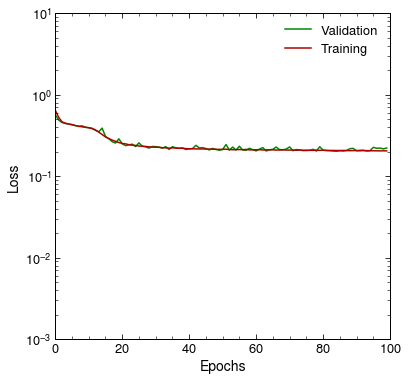

In [12]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,nepochs)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
plt.savefig(plotpath+'loss.pdf')
plt.show()

In [13]:
# get overall performance metric
# performance = model.evaluate(
#     X[test], Y[test],
#     verbose = 0,
# )

# get network scores for the dataset
preds = np.exp(regressor.predict(X[test])*Y_std+Y_mean)

2021-10-11 20:11:48.224151: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_426459"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

243/243 [==============================] - 2s 2ms/step


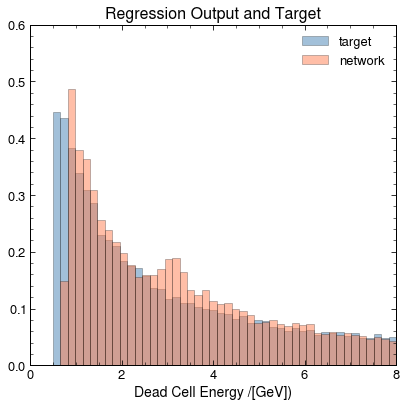

In [14]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(Y[test]*Y_std+Y_mean), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Dead Cell Energy /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
# plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(plotpath+'predictions.pdf')
plt.show()

<Figure size 799.992x599.976 with 0 Axes>

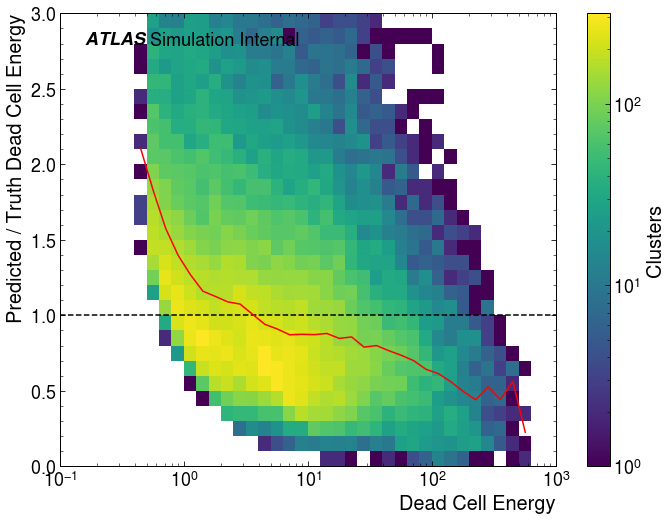

In [15]:
resplot = ru.responsePlot(x=np.exp(Y[test]*Y_std+Y_mean), y=preds/np.exp(Y[test]*Y_std+Y_mean),
                figfile=plotpath+'response.pdf',
                statistic='median', xlabel='Dead Cell Energy', ylabel='Predicted / Truth Dead Cell Energy',
                atlas_x=.05, atlas_y=.96, simulation=True,
                textlist=[])

In [46]:
def Plot2d(x, y, figfile='', statistic='median',
                 xlabel='', ylabel='',
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    ymax = 50
    xbin = [10**exp for exp in np.linspace(0, 3.1, num=40)]
    ybin = np.linspace(0., ymax+.1, num=40)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    profileXMed = scipy.stats.binned_statistic(
        x, y, bins=xbin, statistic=statistic).statistic

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
#     plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.plot(xcenter, profileXMed, color='red')
    plt.xscale('log')
#     plt.yscale('log')
    plt.ylim(0, ymax)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

#     return xcenter, profileXMed

<Figure size 799.992x599.976 with 0 Axes>

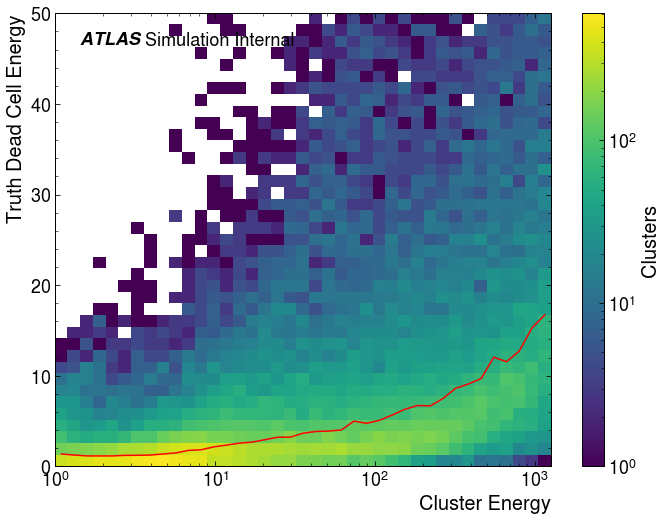

In [47]:
Plot2d(x=np.exp(X[:,0][test]*clusE_std+clusE_mean), y=np.exp(Y[test]*Y_std+Y_mean),
                figfile=plotpath+'clusE_vs_calibDead.pdf',
                statistic='median', xlabel='Cluster Energy', ylabel='Truth Dead Cell Energy',
                atlas_x=.05, atlas_y=.96, simulation=True,
                textlist=[])

<Figure size 799.992x599.976 with 0 Axes>

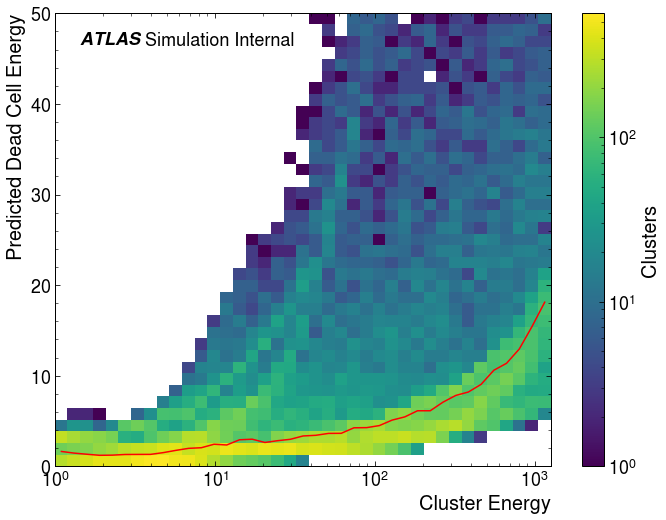

In [48]:
Plot2d(x=np.exp(X[:,0][test]*clusE_std+clusE_mean), y=preds,
                figfile=plotpath+'clusE_vs_pred.pdf',
                statistic='median', xlabel='Cluster Energy', ylabel='Predicted Dead Cell Energy',
                atlas_x=.05, atlas_y=.96, simulation=True,
                textlist=[])

## Variable Correlation

In [7]:
with ur.open(inputpath+'pi0_medium.root') as ifile:
    print(ifile['EventTree'].keys())

['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackEta_PreSamplerB', 'trackPhi_PreSamplerB', 

In [21]:
# with ur.open(inputpath+'pi-graph.root') as ifile:
with ur.open(inputpath+'pi0_medium.root') as ifile:
    pdata = ifile['EventTree'].arrays(cluster_branches)

In [25]:
cluster_branches

['cluster_E',
 'cluster_E_LCCalib',
 'cluster_Pt',
 'cluster_Eta',
 'cluster_Phi',
 'cluster_nCells',
 'cluster_ENG_CALIB_TOT',
 'cluster_ENG_CALIB_OUT_T',
 'cluster_ENG_CALIB_DEAD_TOT',
 'cluster_EM_PROBABILITY',
 'cluster_HAD_WEIGHT',
 'cluster_OOC_WEIGHT',
 'cluster_DM_WEIGHT',
 'cluster_CENTER_MAG',
 'cluster_FIRST_ENG_DENS',
 'cluster_CENTER_LAMBDA',
 'cluster_ISOLATION',
 'cluster_ENERGY_DigiHSTruth',
 'cluster_cell_ID',
 'cluster_cell_E',
 'cluster_hitsTruthIndex',
 'cluster_hitsTruthE']

In [30]:
n_max = 1000000

## Energy Values that are not zero!
sel = (pdata['cluster_E'] != 0) & (pdata['cluster_ENG_CALIB_DEAD_TOT'] > 0.5)

ar = np.array([
    ak.to_numpy(ak.flatten(pdata[branch][sel]))[:n_max]
    for branch in cluster_branches
]).T

# ar = []
# for branch in cluster_branches:
#     print(branch)
#     ar.append([
#         ak.to_numpy(ak.flatten(pdata[branch][sel]))[:n_max]
# ])
# ar = np.array(ar).T

df = pd.DataFrame(ar, columns=[branch for branch in cluster_branches])


In [31]:
df.corr()

,cluster_E,cluster_E_LCCalib,cluster_Pt,cluster_Eta,cluster_Phi,cluster_nCells,cluster_ENG_CALIB_TOT,cluster_ENG_CALIB_OUT_T,cluster_ENG_CALIB_DEAD_TOT,cluster_EM_PROBABILITY,cluster_HAD_WEIGHT,cluster_OOC_WEIGHT,cluster_DM_WEIGHT,cluster_CENTER_MAG,cluster_FIRST_ENG_DENS,cluster_CENTER_LAMBDA,cluster_ISOLATION,cluster_ENERGY_DigiHSTruth
cluster_E,1.000000,0.999613,0.812014,0.000267,0.000219,0.723202,0.998388,0.660191,0.344409,0.260197,-0.221938,-0.344425,-0.264129,-0.016004,0.679855,0.023668,0.158164,NaN
cluster_E_LCCalib,0.999613,1.000000,0.804764,0.000356,0.000139,0.720814,0.997802,0.668381,0.355089,0.255186,-0.218619,-0.345429,-0.263057,-0.006227,0.679091,0.026001,0.161723,NaN
cluster_Pt,0.812014,0.804764,1.000000,-0.000896,-0.000291,0.792058,0.812089,0.218038,0.273400,0.216362,-0.173011,-0.294351,-0.219420,-0.306464,0.375907,0.054160,0.134541,NaN
cluster_Eta,0.000267,0.000356,-0.000896,1.000000,-0.000606,0.000020,0.000504,0.003175,-0.004492,0.001016,-0.000562,0.002509,0.004872,0.001845,-0.000220,-0.004908,0.002249,NaN
cluster_Phi,0.000219,0.000139,-0.000291,-0.000606,1.000000,-0.000346,0.000691,0.001640,-0.011473,0.001304,0.000587,0.000775,-0.001311,0.000731,0.001968,-0.001409,0.005745,NaN
cluster_nCells,0.723202,0.720814,0.792058,0.000020,-0.000346,1.000000,0.721173,0.286468,0.307690,0.312280,-0.122183,-0.425761,-0.287384,-0.297849,0.398361,0.012793,0.287345,NaN
cluster_ENG_CALIB_TOT,0.998388,0.997802,0.812089,0.000504,0.000691,0.721173,1.000000,0.664653,0.312711,0.259108,-0.216407,-0.337649,-0.262844,-0.022304,0.679746,0.020298,0.157801,NaN
cluster_ENG_CALIB_OUT_T,0.660191,0.668381,0.218038,0.003175,0.001640,0.286468,0.664653,1.000000,0.192727,0.284482,-0.208727,-0.269078,-0.253027,0.320603,0.677264,-0.081480,0.198278,NaN
cluster_ENG_CALIB_DEAD_TOT,0.344409,0.355089,0.273400,-0.004492,-0.011473,0.307690,0.312711,0.192727,1.000000,0.047513,-0.082069,-0.216054,-0.082317,0.121518,0.124037,0.110843,0.044489,NaN
cluster_EM_PROBABILITY,0.260197,0.255186,0.216362,0.001016,0.001304,0.312280,0.259108,0.284482,0.047513,1.000000,-0.463742,-0.247328,-0.176505,-0.199916,0.201567,-0.574805,0.412435,NaN


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


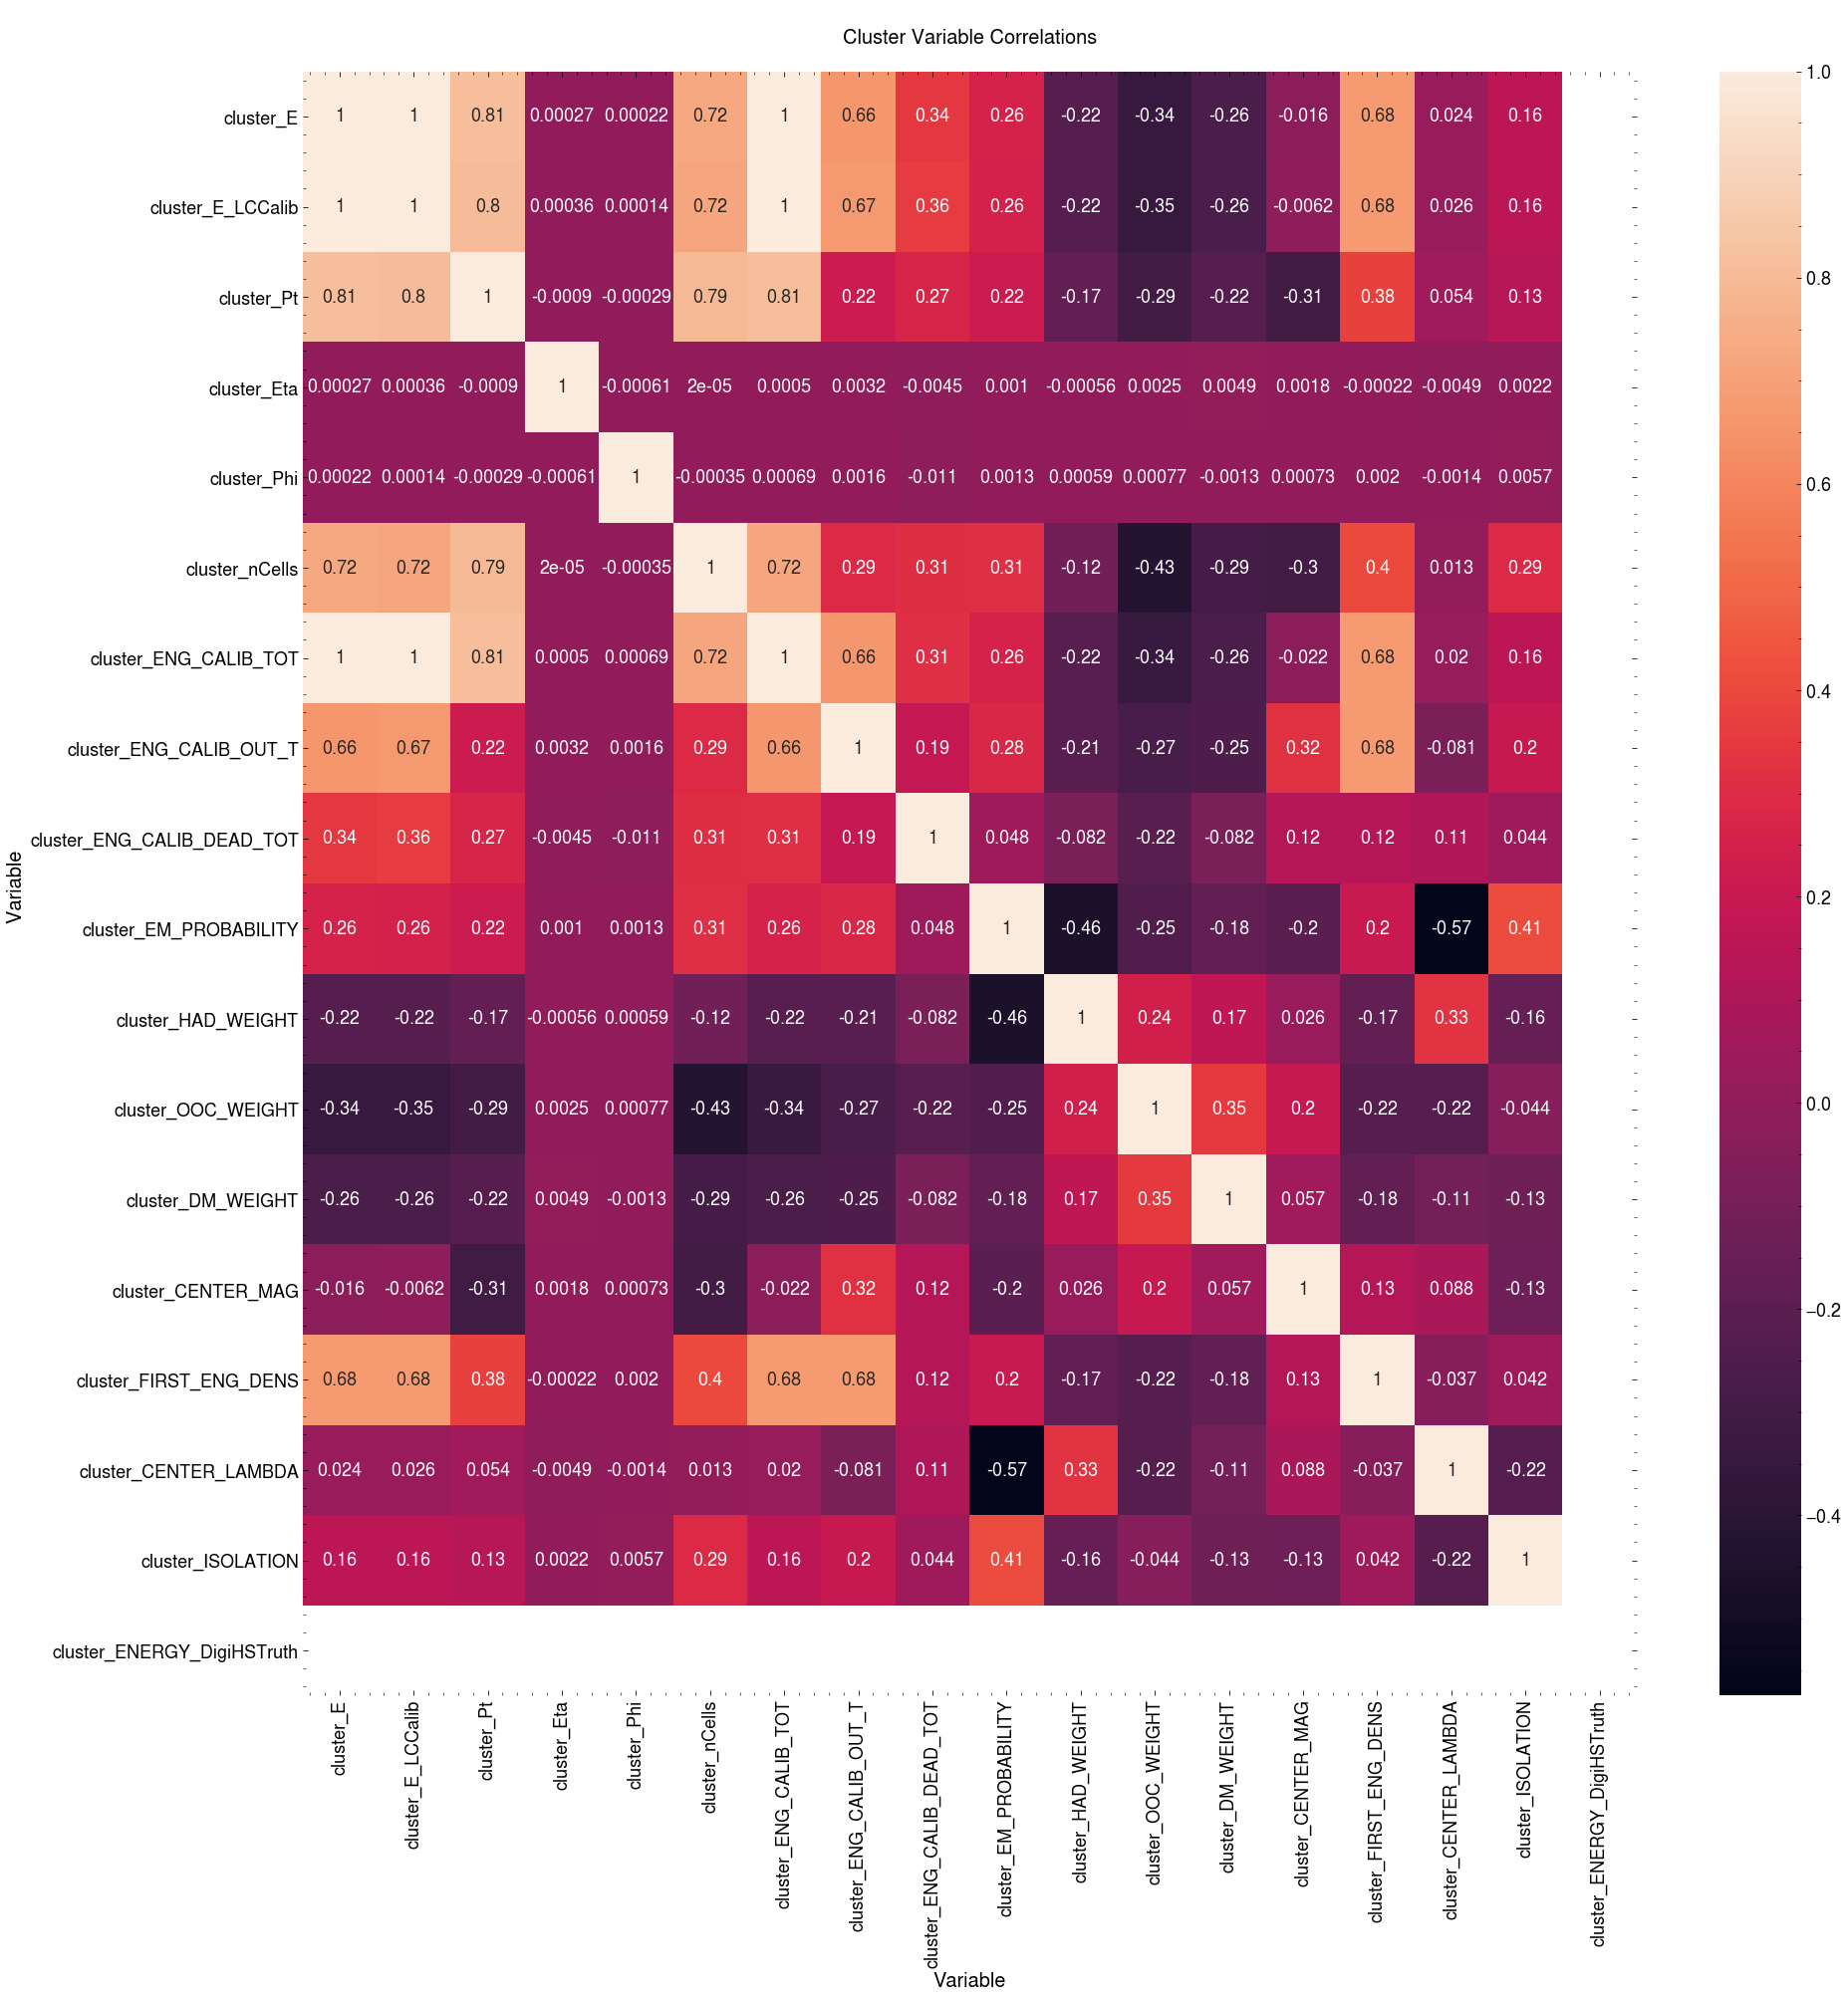

In [37]:
import seaborn as sns
fig = plt.figure(figsize=(30,30))
hm = sns.heatmap(df.corr(), annot = True)
hm.set(title = "\nCluster Variable Correlations\n",
       xlabel='Variable',
       ylabel='Variable\t'
      )

plt.savefig(plotpath+'corr.pdf')